<a href="https://colab.research.google.com/github/seanmcalevey/kaggle_challenges/blob/master/Kaggle_Disaster_Tweet_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [0]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

### Import Data

In [0]:
os.chdir('/content')

df = pd.read_csv('train-kaggle-nlp.csv')

df.sample(8)

,id,keyword,location,text,target
5975,8531,screaming,justin & ari follow || tvd,@justinbieber @ArianaGrande SCREAMING,0
5629,8029,refugees,NaN,Short of throwing them overboard himself I don't think any other leader could do much worse by #...,1
3342,4786,evacuated,NaN,ALERT! Sandy Hook Elementary School Evacuated After Û÷Bomb ThreatÛª http://t.co/LwLexXjUS8,1
913,1320,bloody,Storybrooke,@chxrmingprince @jones_luna I should bloody hope so *she said folding her arms sitting back in h...,0
6435,9208,suicide%20bombing,NaN,@JewhadiTM It is almost amazing to think someone thought suicide bombing would actually be a goo...,1
4936,7031,mayhem,NaN,Slayer Reflects on Low Mayhem Festival Attendance King Diamond &amp; Jeff Hanneman's Passing htt...,0
1323,1914,burning,Australian Capital Territory,#?x?: :and to counter acts such as the burning of the Alexandrian library.,1
1093,1579,bombed,"Dundas, Ontario",Jays rocking #MLB @JoeyBats19 just bombed one out of Rogers Centre. Play-offs r ahead for The #B...,0


### Import Custom Function to Replace Contractions

In [0]:
import os

os.chdir('/content/drive/My Drive')

from summarizer_func_lib import replace_contraction

### Clean Tweets

In [0]:
clean_text = [re.sub('[^A-Za-z.@\-\#\'\s]', '', str(text)) for text in df['text']]

split_word_nars = [tweet.split() for tweet in clean_text]

new_words = []

for nar in split_word_nars:
    
  nar_words = []

  for word in nar:

    if re.search('\w+[.]', word):

      splitted = word.split('.')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

        nar_words.append('.')
    
    elif re.search('\w+[;]', word):
        
      splitted = word.split(';')
      
      tmp_words = replace_contraction(splitted[0].lower())
      
      for w in tmp_words.split():
          
        nar_words.append(w)
        
        nar_words.append(';')

    elif re.search('\#\w+', word):

      splitted = word.split('#')

      tmp_words = replace_contraction(splitted[1].lower())

      for w in tmp_words.split():

        nar_words.append('#') # reverse order because of # coming before words

        nar_words.append(w)
    
    elif re.search('@\w+', word):

      splitted = word.split('@')

      tmp_words = replace_contraction(splitted[1].lower())

      for w in tmp_words.split():

        nar_words.append('@')

        nar_words.append(w)
    
    elif re.search('\w+\-\w+', word):

      splitted = word.split('-')

      tmp_words = replace_contraction(splitted[0]. lower())

      for w in tmp_words.split():

        nar_words.append(w)
      
      tmp_words = replace_contraction(splitted[1].lower())

      for w in tmp_words.split():

        nar_words.append(w)

    else:

      tmp_words = replace_contraction(word)

      for w in tmp_words.split():

        nar_words.append(w)

  nar_words = [word for word in nar_words]

  new_words.append(' '.join(nar_words))

texts = new_words

df['clean_text'] = texts

### Lemmatize Cleaned Text (Optional, Dependent on Model Scores)

In [0]:
import spacy

lemmatizer = spacy.load('en', disable=['parser', 'ner'])

lem_texts = []

for text in texts:

  lems = lemmatizer(text)

  true_lems = [token.lemma_ for token in lems]

  lem_texts.append(true_lems)

df['lem_text'] = lem_texts

### View Text Samples

In [0]:
pd.set_option('display.max_colwidth', 100)

df['clean_text'].sample(10)

3548    @ robertmeyer re your example low food prices cause farmers to go broke famine next year . means...
5067                 Suncorp net profit rises to . billion in worst year of natural disaster claims httpt .
1735    Crews working to restore power in southwest Omaha after vehicle collided with utility pole . - h...
7562                                                                             you wrecked my whole world
7453                         and I thought my surgical wounds were healed this weather ain't helping either
1234                                       Fire destroys two buildings on nd Street in # manchester httpt .
793                                                        @ demetae yes i want to be the new blight leader
1051    Womens Handbags Cross Body Geometric Pattern Satchel Totes Shoulder Bags White httpt . httpt . R...
2940                               Toddler drowned in bath after mum left room to fetch his pyjamas httpt .
3806                Former T

### Convert Locations to All Lowercase

In [0]:
clean_locs = []

for loc in df['location']:
  
  try:

    lowered = loc.lower()

    clean_locs.append(lowered)
  
  except:

    clean_locs.append(loc)

df['location'] = clean_locs

### Train Test Split

In [0]:
from sklearn.model_selection import train_test_split

X = df[['clean_text', 'keyword', 'location']]

y = np.asarray(df['target']).reshape(-1,1)

X_trainval, X_test_full, y_trainval, y_test = train_test_split(X, y, test_size=200, stratify=y, random_state=42)

X_train_full, X_val_full, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=500, stratify=y_trainval,
                                                  random_state=42)

### Split into Text Data and Categorical Data

In [0]:
X_train, X_val, X_test = X_train_full['clean_text'], X_val_full['clean_text'], X_test_full['clean_text']

### Tokenizer

In [0]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer

corpus = list(X_train) + list(X_val) + list(X_test)

max_words = 6553

tokenizer = Tokenizer(num_words=max_words, filters='')

tokenizer.fit_on_texts(corpus)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

X_voc_size = max_words + 1

X_voc_size

6554

### Import and Use Max_Word_Calc Func to Re-Tokenize

In [0]:
from summarizer_func_lib import max_word_calc

min_count = 2

max_word_count = max_word_calc(tokenizer, min_count=min_count)

max_word_count

6553

### Pad Sequences

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len_text = 50

X_train = pad_sequences(X_train, maxlen=max_len_text, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len_text, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len_text, padding='post')

### Build Model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, Input
from tensorflow.keras.regularizers import l1, l2

n_neurons = 256

emb_dim = 256

emb_reg, layer_reg = l2(1e-8), l1(1e-8)

dropout_rate = 0.5

model = Sequential()

model.add(Input(shape=[max_len_text,]))

model.add(Embedding(X_voc_size, emb_dim, embeddings_regularizer=emb_reg, trainable=True))

model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(n_neurons, return_sequences=True, return_state=False,
                             dropout=dropout_rate, kernel_regularizer=layer_reg)))

model.add(Dense(n_neurons, activation='relu', kernel_regularizer=layer_reg))

model.add(Dropout(dropout_rate))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 256)           1677824   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 512)           1050624   
_________________________________________________________________
dense_4 (Dense)              (None, 50, 256)           131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 50, 1)             257       
Total params: 2,860,033
Trainable params: 2,860,033
Non-trainable params: 0
____________________________________________

### Generate Image of Architecture

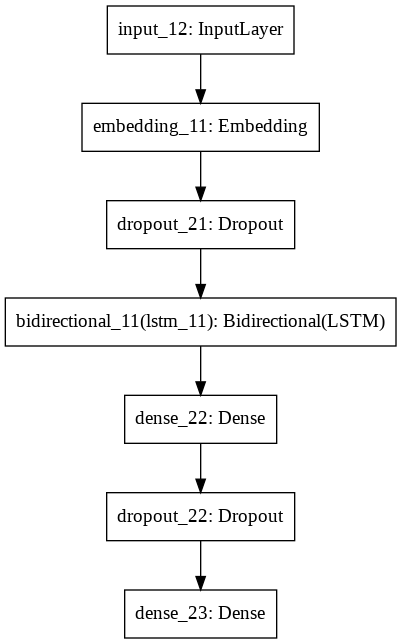

In [0]:
tensorflow.keras.utils.plot_model(model)

### Checkpoints

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Early Stopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Checkpointing Model Weights

import os

checkpoint_path = 'checkpoints/cp-{epoch:03d}.ckpt'

checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, period=1)

latest_checkpoint = tensorflow.train.latest_checkpoint(checkpoint_dir)

latest_checkpoint

'checkpoints/cp-004.ckpt'

### Training

In [0]:
batch_size = 256

epochs = 12

# model.load_weights(latest_checkpoint)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs,
                    callbacks=[early_stop, checkpoint_cb])

Epoch 1/12


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


27/28 [===========================>..] - ETA: 0s - loss: 0.6740 - accuracy: 0.5914
Epoch 00001: saving model to checkpoints/cp-001.ckpt
28/28 [==============================] - 2s 83ms/step - loss: 0.6740 - accuracy: 0.5913 - val_loss: 0.6053 - val_accuracy: 0.7078
Epoch 2/12
27/28 [===========================>..] - ETA: 0s - loss: 0.5818 - accuracy: 0.7178
Epoch 00002: saving model to checkpoints/cp-002.ckpt
28/28 [==============================] - 1s 45ms/step - loss: 0.5818 - accuracy: 0.7178 - val_loss: 0.5609 - val_accuracy: 0.7319
Epoch 3/12
27/28 [===========================>..] - ETA: 0s - loss: 0.5111 - accuracy: 0.7705
Epoch 00003: saving model to checkpoints/cp-003.ckpt
28/28 [==============================] - 1s 51ms/step - loss: 0.5110 - accuracy: 0.7705 - val_loss: 0.5414 - val_accuracy: 0.7363
Epoch 4/12
27/28 [===========================>..] - ETA: 0s - loss: 0.4696 - accuracy: 0.7937
Epoch 00004: saving model to checkpoints/cp-004.ckpt
28/28 [==========================

### Process Categorical Data Along with Results from Text

In [0]:
X_train_cat, X_val_cat, X_test_cat = X_train_full[['keyword', 'location']], X_val_full[['keyword', 'location']], X_test_full[['keyword', 'location']]

X_train_cat = X_train_cat.replace({np.nan: 'nan'})

X_val_cat = X_val_cat.replace({np.nan: 'nan'})

X_test_cat = X_test_cat.replace({np.nan: 'nan'})

### Get Prediction Vectors from RNN

In [0]:
X_text_train = model.predict(X_train)

X_text_val = model.predict(X_val)

X_text_test = model.predict(X_test)

### Select the Final Timestep


In [0]:
X_text_train = X_text_train[:, -1, 0]

X_text_val = X_text_val[:, -1, 0]

X_text_test = X_text_test[:, -1, 0]

### Combine into Single DF

In [0]:
X_train_cat['text_encoded'] = X_text_train

X_val_cat['text_encoded'] = X_text_val

X_test_cat['text_encoded'] = X_text_test

In [0]:
X_train_complete = X_train_cat

X_val_complete = X_val_cat

X_test_complete = X_test_cat

### Preprocessing

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

num_proc = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())

col_proc = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((num_proc, ['text_encoded']), (col_proc, ['keyword', 'location']))

In [0]:
y_train, y_val, y_test = y_train.reshape(-1), y_val.reshape(-1), y_test.reshape(-1)

## Train

### Random Forest Clf

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(preprocessor, RandomForestClassifier())

param_grid = {'randomforestclassifier__max_depth': [2,3,4]}

rf_grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_complete, y_train)

print(f'Best params: {rf_grid.best_params_}')

print(f'Mean cross validation score: {max(rf_grid.cv_results_["mean_test_score"])}')

Best params: {'randomforestclassifier__max_depth': 4}
Mean cross validation score: 0.5927956067735882


### Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = make_pipeline(preprocessor, GradientBoostingClassifier())

param_grid = {'gradientboostingclassifier__max_depth': [2,3,4]}

gb_grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_complete, y_train)

print(f'Best params: {gb_grid.best_params_}')

print(f'Mean cross validation score: {max(gb_grid.cv_results_["mean_test_score"])}')

Best params: {'gradientboostingclassifier__max_depth': 2}
Mean cross validation score: 0.8546213950042537


### XGBoost

In [0]:
# ! pip install xgboost

In [0]:
from xgboost import XGBClassifier

pipe = make_pipeline(preprocessor, XGBClassifier())

param_grid = {'xgbclassifier__max_depth': [2,3,4]}

xgb_grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_complete, y_train)

print(f'Best params: {xgb_grid.best_params_}')

print(f'Mean cross validation score: {max(xgb_grid.cv_results_["mean_test_score"])}')

Best params: {'xgbclassifier__max_depth': 2}
Mean cross validation score: 0.8546214996447455


### AdaBoost

In [0]:
from sklearn.ensemble import AdaBoostClassifier

pipe = make_pipeline(preprocessor, AdaBoostClassifier())

param_grid = {'adaboostclassifier__n_estimators': [200]}

ada_grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_complete, y_train)

print(f'Best params: {ada_grid.best_params_}')

print(f'Mean cross validation score: {max(ada_grid.cv_results_["mean_test_score"])}')

Best params: {'adaboostclassifier__n_estimators': 200}
Mean cross validation score: 0.8460861840019337


### Support Vector Classifier

In [0]:
from sklearn.svm import LinearSVC

pipe = make_pipeline(preprocessor, LinearSVC())

param_grid = {'linearsvc__C': [5e-3, 1e-2, 5e-2]}

svc_grid = GridSearchCV(pipe, param_grid, cv=5).fit(X_train_complete, y_train)

print(f'Best params: {svc_grid.best_params_}')

print(f'Mean cross validation score: {max(svc_grid.cv_results_["mean_test_score"])}')

Best params: {'linearsvc__C': 0.05}
Mean cross validation score: 0.8520179395659303


## Validate Scores

In [0]:
print('Random forest:', rf_grid.score(X_val_complete, y_val))

print('Grad Boost:', gb_grid.score(X_val_complete, y_val))

print('XGB:', xgb_grid.score(X_val_complete, y_val))

print('AdaBoost:', ada_grid.score(X_val_complete, y_val))

print('SVC:', svc_grid.score(X_val_complete, y_val))

Random forest: 0.57
Grad Boost: 0.74
XGB: 0.736
AdaBoost: 0.724
SVC: 0.746


In [0]:
print('SVC test score:', svc_grid.score(X_test_complete, y_test))

SVC test score: 0.81


## Run on Test CSV Data

In [0]:
os.chdir('/content')

test_df = pd.read_csv('test (1).csv')

test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
import os

os.chdir('/content/drive/My Drive')

from summarizer_func_lib import replace_contraction

### Preprocess Test Data

In [0]:
clean_text = [re.sub('[^A-Za-z.@\-\#\'\s]', '', str(text)) for text in test_df['text']]

split_word_nars = [tweet.split() for tweet in clean_text]

new_words = []

for nar in split_word_nars:
    
  nar_words = []

  for word in nar:

    if re.search('\w+[.]', word):

      splitted = word.split('.')

      tmp_words = replace_contraction(splitted[0].lower())

      for w in tmp_words.split():

        nar_words.append(w)

        nar_words.append('.')
    
    elif re.search('\w+[;]', word):
        
      splitted = word.split(';')
      
      tmp_words = replace_contraction(splitted[0].lower())
      
      for w in tmp_words.split():
          
        nar_words.append(w)
        
        nar_words.append(';')

    elif re.search('\#\w+', word):

      splitted = word.split('#')

      tmp_words = replace_contraction(splitted[1].lower())

      for w in tmp_words.split():

        nar_words.append('#') # reverse order because of # coming before words

        nar_words.append(w)
    
    elif re.search('@\w+', word):

      splitted = word.split('@')

      tmp_words = replace_contraction(splitted[1].lower())

      for w in tmp_words.split():

        nar_words.append('@')

        nar_words.append(w)
    
    elif re.search('\w+\-\w+', word):

      splitted = word.split('-')

      tmp_words = replace_contraction(splitted[0]. lower())

      for w in tmp_words.split():

        nar_words.append(w)
      
      tmp_words = replace_contraction(splitted[1].lower())

      for w in tmp_words.split():

        nar_words.append(w)

    else:

      tmp_words = replace_contraction(word)

      for w in tmp_words.split():

        nar_words.append(w)

  nar_words = [word for word in nar_words]

  new_words.append(' '.join(nar_words))

texts = new_words

test_df['clean_text'] = texts

In [0]:
clean_locs = []

for loc in test_df['location']:
  
  try:

    lowered = loc.lower()

    clean_locs.append(lowered)
  
  except:

    clean_locs.append(loc)

test_df['location'] = clean_locs

In [0]:
proc_text = test_df['clean_text']

proc_text = tokenizer.texts_to_sequences(proc_text)

proc_text = pad_sequences(proc_text, maxlen=max_len_text, padding='post')

pred_text = model.predict(proc_text)

In [0]:
test_df['text_encoded'] = pred_text[:, -1, 0]

predictions = grid.predict(test_df)

test_df['target'] = predictions

/usr/local/lib/python3.6/dist-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


### Get Pred Output for TestDF

In [0]:
final_df = test_df[['id', 'target']]

os.chdir('/content')

final_df.to_csv('/content/drive/My Drive/nlp_disaster_tweet_preds.csv', header=['id', 'target'], index=False)

In [0]:
final_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
